Forecasting BTC-USD price using ARIMA (basically backtesting) <br>
I am really sorry if this jupyter notebook is not tidy, I did my best

## Importing Data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [17]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [18]:
import yfinance as yf
ticker_symbol = 'BTC-USD'
data = yf.download(ticker_symbol, start='2023-06-28', end='2024-06-28')
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2023-06-28  30696.560547  30703.279297  29921.822266  30086.246094   
2023-06-29  30086.187500  30796.250000  30057.203125  30445.351562   
2023-06-30  30441.353516  31256.863281  29600.275391  30477.251953   
2023-07-01  30471.847656  30641.289062  30328.865234  30590.078125   
2023-07-02  30587.269531  30766.140625  30264.019531  30620.769531   

               Adj Close       Volume  
Date                                   
2023-06-28  30086.246094  14571500779  
2023-06-29  30445.351562  13180860821  
2023-06-30  30477.251953  26387306197  
2023-07-01  30590.078125   9086606733  
2023-07-02  30620.769531  10533418042  


In [19]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-28,30696.560547,30703.279297,29921.822266,30086.246094,30086.246094,14571500779
2023-06-29,30086.187500,30796.250000,30057.203125,30445.351562,30445.351562,13180860821
2023-06-30,30441.353516,31256.863281,29600.275391,30477.251953,30477.251953,26387306197
2023-07-01,30471.847656,30641.289062,30328.865234,30590.078125,30590.078125,9086606733
2023-07-02,30587.269531,30766.140625,30264.019531,30620.769531,30620.769531,10533418042


Use close price because it is commonly used

In [20]:
df = data[['Close']]

In [21]:
df.head()

,Close
Date,
2023-06-28,30086.246094
2023-06-29,30445.351562
2023-06-30,30477.251953
2023-07-01,30590.078125
2023-07-02,30620.769531


In [22]:
df.shape

(366, 1)

## Exploration before Differencing

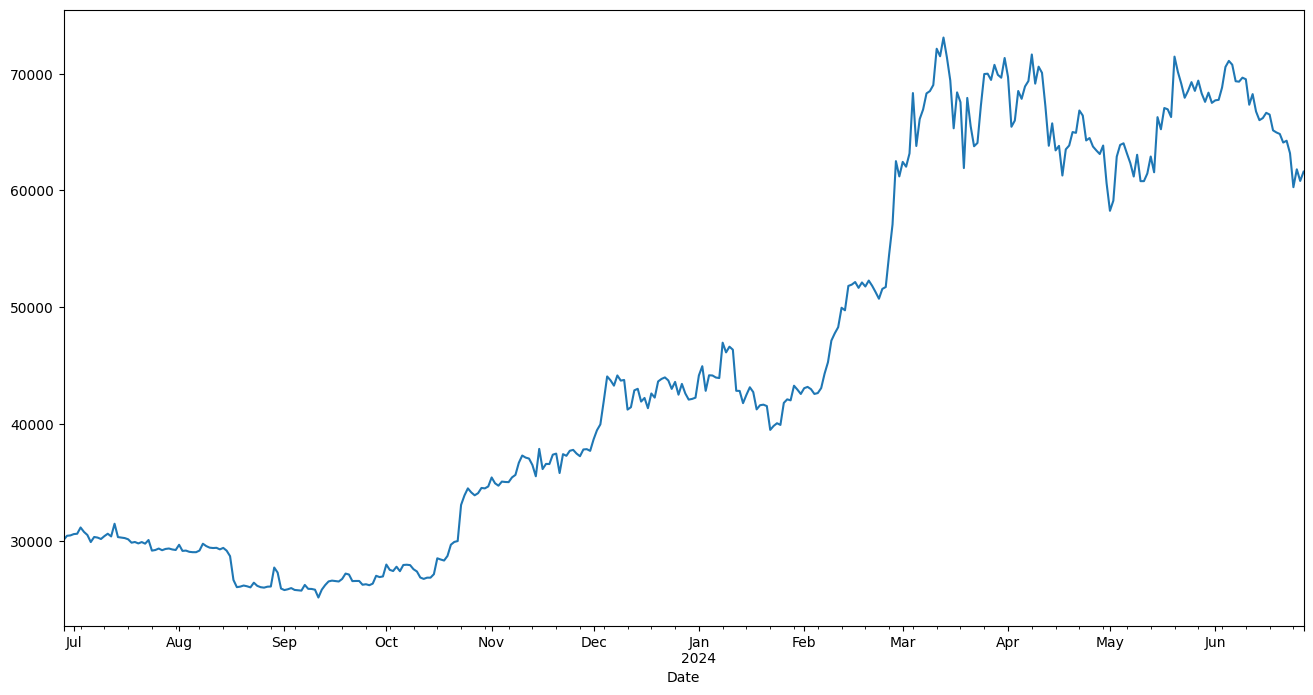

In [23]:
plt.figure(figsize = (16,8))
df['Close'].plot();

From this we can see the uprising trend of the price. <br>
I don't seem to see the seasonality from this data

## ADF TEST (Stationarity)

In [24]:
def adf_test(timeseries):
    print('Result of Augmented Dickey-fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [25]:
adf_test(df['Close'])

Result of Augmented Dickey-fuller Test
Test Statistic                  -0.931287
p-value                          0.777495
#Lags Used                      14.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


## Augmented Dickey Fuller Test
Extension of the normal Dickey-Fullter test for more complex model than AR(1). ADF used for larger sized set of time series models which can be more complicated.
<br>
This test under the following assumption: <br>
1. **Null Hypothesis $(H_{0})$:** There exists a unit root in the time series and it is non-stationary. **Unit root = 1** or **$\delta=0$**.
2. **Alternate Hypothesis $(H_{1})$:** There exist no unit root in the time series and it is stationary. **Unit root < 1** or **$\delta<0$**.

### Explanation
Based on the Test Statistic, the value is much higher than critical value (5%) meaning cannot reject the null hypothesis proving the time series is non-stationary <br>
The p-value also greater than common significance like 0.05 meaning not enough evidence to reject the null hypothesis meaning the time series is non-stationary <br>


## Differencing
One famous way to turn non-stationary into stationaryis differencing, differencing is usually done in only 0,1, and at most 2 order. <br>
Lets try 1st differencing

In [26]:
df_diff = df.diff()
df_diff = df_diff.dropna()

In [27]:
df_diff.head()

,Close
Date,
2023-06-29,359.105469
2023-06-30,31.900391
2023-07-01,112.826172
2023-07-02,30.691406
2023-07-03,535.669922


In [30]:
adf_test(df_diff['Close'])

Result of Augmented Dickey-fuller Test
Test Statistic                  -3.878210
p-value                          0.002201
#Lags Used                      13.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


The Test Statistic is lower than any of the critical value meaning having evidence against the null hypotesis and accepting the alternate hypothesis, indicating stationary time series, <br>
The p value is lower than most common significance level 0.05, indicating stationary time series.

## PACF and ACF PLOT
To determine the (p and q) parameter of AR(p), MA(q), ARMA(p,q), ARIMA(p,d,q), and SARIMA(p,d,q)(P,D,Q,s). We need to use PACF for the p and ACF for the q, the d is for differencing because ARIMA including differencing in the model. <br>
We also going to explore auto.arima functing from pmdarima.